# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
push!(LOAD_PATH,".")
using PyPlot, HDF5
using Statistics

In [3]:
using SacaDatos
using Detectores

In [4]:
nomine = "/home/karel/ABFiles/Jose/180718_9.hf5"

"/home/karel/ABFiles/Jose/180718_9.hf5"

In [5]:
datos = h5open(nomine, "r");
names(datos)

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5F.c line 370 in H5Fis_hdf5(): unable open file
    major: File accessibilty
    minor: Not an HDF5 file
  #001: H5Fint.c line 802 in H5F__is_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #002: H5FD.c line 734 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = '/home/karel/ABFiles/Jose/180718_9.hf5', errno = 2, error message = 'No existe el fichero o el directorio', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


ErrorException: Cannot access file /home/karel/ABFiles/Jose/180718_9.hf5

In [5]:
datos

HDF5 data file: /home/karel/ABFiles/Jose/180718_9.hf5

In [6]:
constantes, sweps = devuelvedatos(datos, "Im_primaryIm_sec");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5.HDF5Compound{3}((0.04, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 25.0 kHz.


In [7]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const postG=round(Int, postGms*freq)
println(preG," ", postG)

250 1000


# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [8]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [9]:
suaves=Dict{String, Array}()
derivadas=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    #aqui esta mal la escala de frecuencias, NO DEJAR DE ESPECIFICAR LA FREQ DE MUESTREO
    # 0.4 ms son  10 cuadritos
    suaves[subs]=suavegauss(sweps[subs], dt=0.4, freq=freq)
    derivadas[subs]=derivadadt(suaves[subs],freq=freq)
end

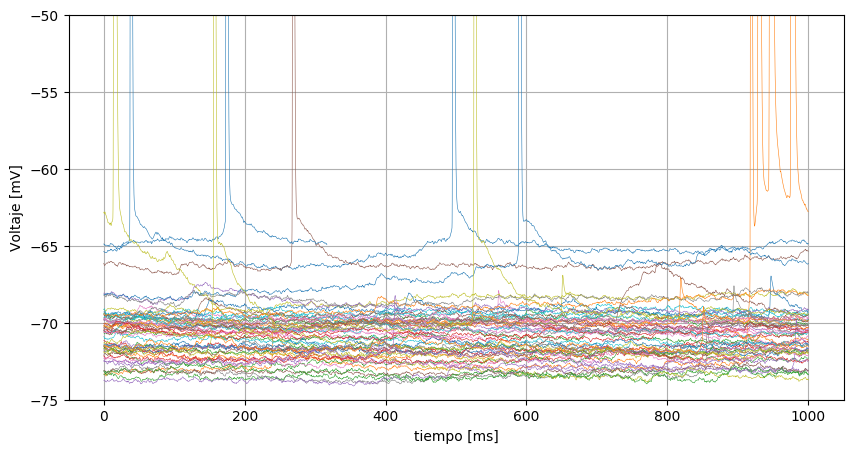

In [10]:
figura=figure(figsize=(10,5))
ylim(-75,-50)

for subs in keys(suaves)
#subs="section_44"

   lala=length(suaves[subs])
   rangot=iart(1, lala, freq=freq)  
  plot(rangot,suaves[subs], label=subs, lw=0.4)
end

xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
#legend()
grid()

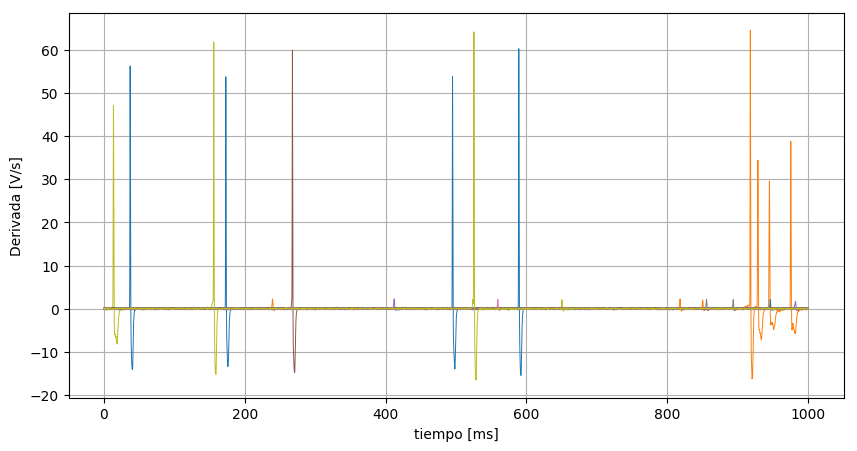

In [11]:
figura=figure(figsize=(10,5))
#ylim(-0.02, 0.5)
for subs in keys(derivadas)
lala=length(derivadas[subs])
rangot=iart(1, lala, freq=freq)    
 plot(rangot,derivadas[subs], label=subs, lw=0.7)
end
xlabel("tiempo [ms]")
ylabel("Derivada [V/s]")
#legend()
grid()


In [12]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(derivadas)
    println(subs)
   intSS[subs]=intervalosP(derivadas[subs], preG=preG, postG=postG, uinf=1.5, usup=12.5)
end

section_57
53.839369659207925
56.24727621255072
section_44
29.56144750970857
64.52888222997561
34.427788048166796
38.802828035157866
2.2701333013078084
vamos bien, 5738 6988 2.2701333013078084
section_06
no hay naaaaaada en esa seccion
section_13
no hay naaaaaada en esa seccion
section_17
no hay naaaaaada en esa seccion
section_56
59.938548099787425
section_12
no hay naaaaaada en esa seccion
section_41
2.1848843903079285
vamos bien, 21138 22388 2.1848843903079285
section_16
2.091532496833537
vamos bien, 16009 17259 2.091532496833537
section_09
no hay naaaaaada en esa seccion
section_58
53.742245612428086
section_07
no hay naaaaaada en esa seccion
section_43
no hay naaaaaada en esa seccion
section_29
no hay naaaaaada en esa seccion
section_39
no hay naaaaaada en esa seccion
section_40
no hay naaaaaada en esa seccion
section_10
no hay naaaaaada en esa seccion
section_04
no hay naaaaaada en esa seccion
section_45
47.10251550030531
section_00
no hay naaaaaada en esa seccion
section_32
no h

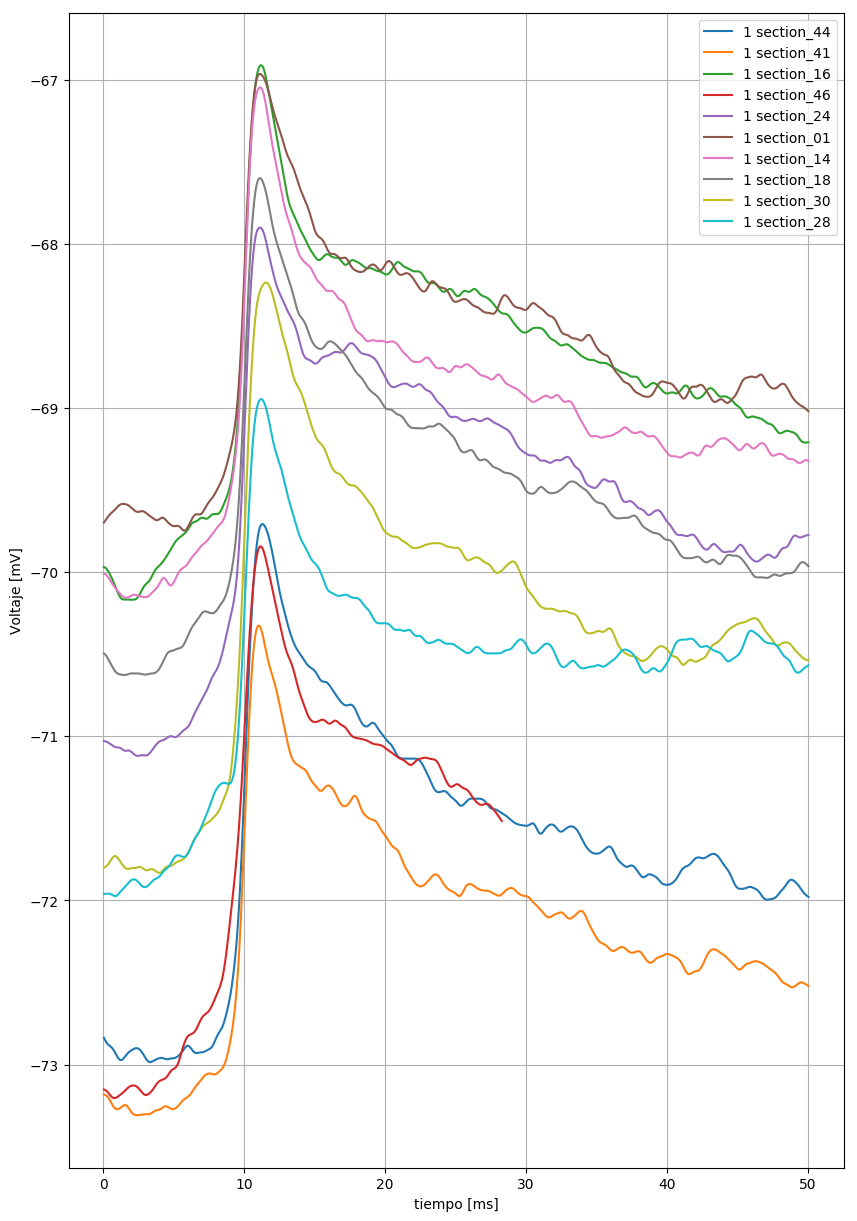

In [13]:
figura=figure(figsize=(10,15))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
#    subs="section_44"
    a=0
    for j in keys(intSS[subs])
        a=a+1
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll, freq=freq)
        plot(rangot,suaves[subs][rango], label="$j "*subs)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
legend()
grid()

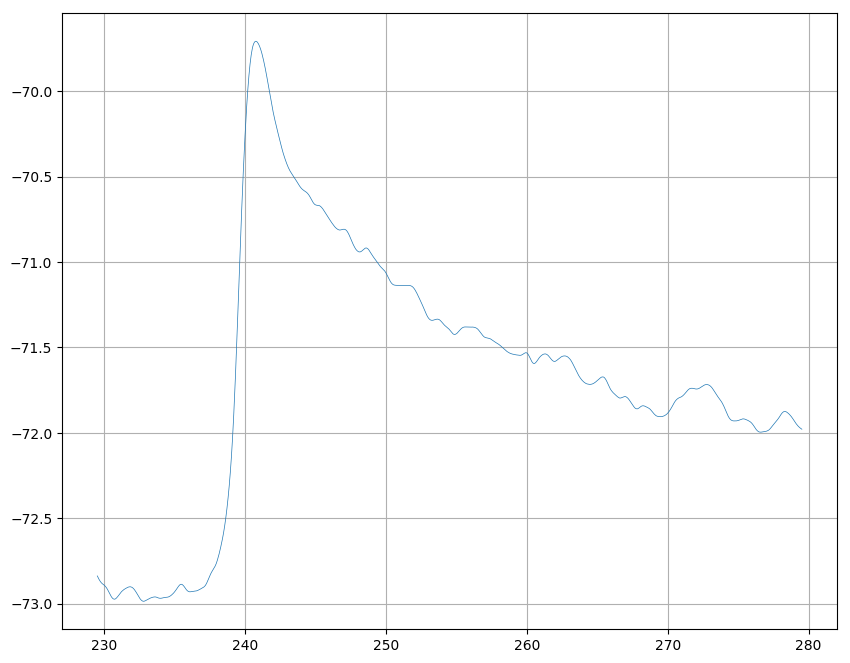

In [14]:
figura=figure(figsize=(10,8))

ss="section_44"

brango=1:length(suaves[ss])
brango=brango./freq
#plot(brango,suaves["section_44"], lw=0.4)

a=0
  for j in keys(intSS[ss])
        a=a+1
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[ss][j]
        rangot=iart(rango[1],rango[end], freq=freq)
        plot(rangot,suaves[ss][rango], label=j, lw=0.5)
    end
grid()

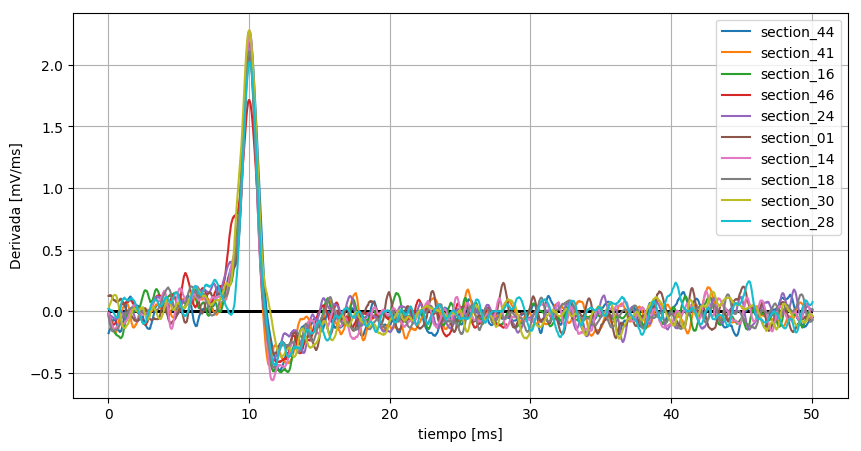

PyObject <matplotlib.legend.Legend object at 0x7f969401bf28>

In [15]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,derivadas[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Derivada [mV/ms]")
grid()
legend()

In [16]:
(limpia, mocha)=separamochas(intSS, preG, postG);

In [17]:
ddt=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    ddt[subs]=derivadadt(derivadas[subs])    
end

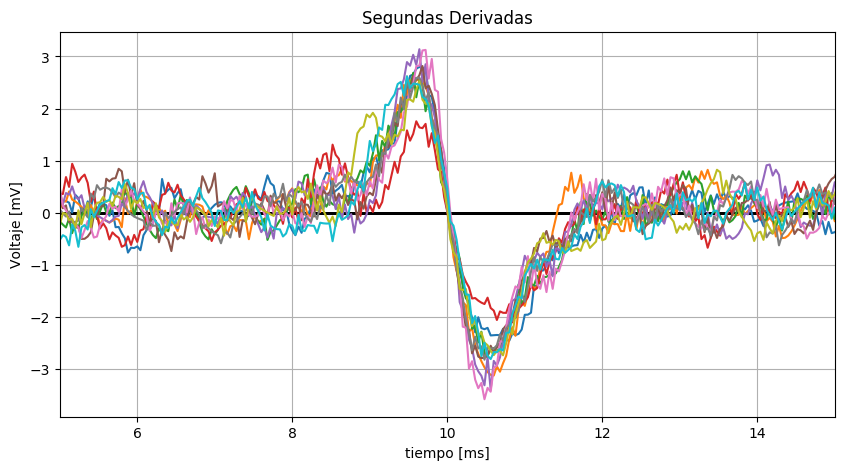

In [18]:
figura=figure(figsize=(10,5))

title("Segundas Derivadas")

xlim(5,15)
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,ddt[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
#legend()

In [19]:
promSpk=averagedictdict(limpia, suaves); # de ahora en adelante asi se sacan promedios sobre intervalos!


In [74]:
normalized=normCut(suaves, limpia)

MethodError: MethodError: no method matching normCut(::Dict{String,Array}, ::Dict{String,Dict})
Closest candidates are:
  normCut(::Any, ::Any, !Matched::Any) at In[20]:3

In [75]:
derivadalimpia=Dict{String, Dict{Int64, Array}}()
for k in keys(normalized)
    derivadalimpia[k]=Dict{Int64,Array}()
    for j in keys(normalized[k])
        derivadalimpia[k][j]=derivadadt(normalized[k][j], freq=freq)
    end
end

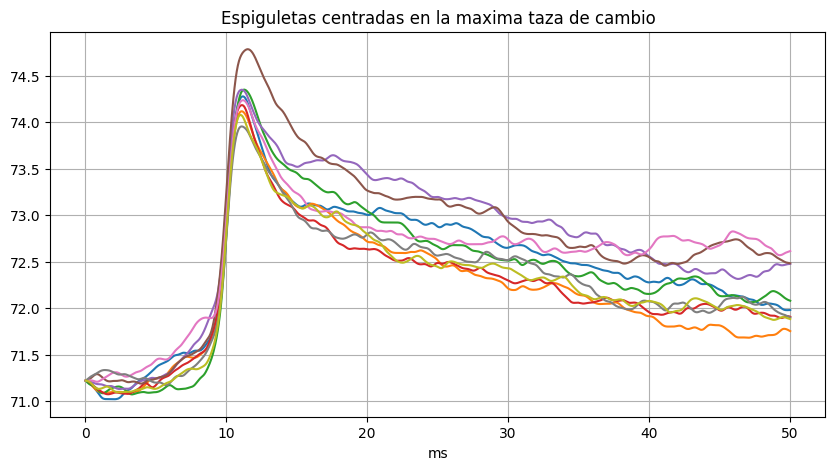

In [77]:
figura=figure(figsize=(10,5))
rangot=0
title("Espiguletas centradas en la maxima taza de cambio")
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normalized)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normalized[subs])
           rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll, freq=freq)
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(rangot,normalized[subs][j])
    end
end

 xlabel("ms")
grid()
#plot(a, lw=3)

**NOTA para avanzar**

En la grafica superior, la linea gruesa es el promedio. Nos interesa calcular el tiempo que le lleva levantarse desde
el cambio en la curvatura (suave a muy empinado) hasta el máximo punto de la funcion.

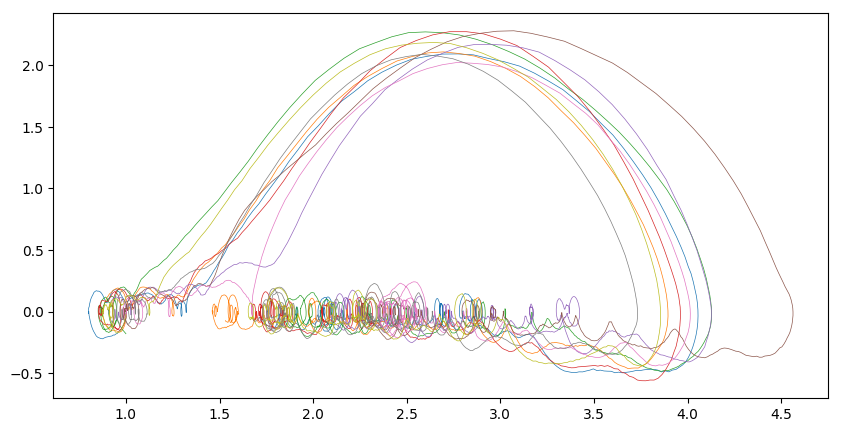

In [78]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), derivadas[subs][rango], lw=0.5)
    end
end
#plot(promSpK[2:end],difProm, lw=5, c="red")

In [25]:
difProm=derivadadt(promSpk)
ddprom=derivadadt(difProm);

In [26]:
riset=risetime(difProm)

(217, 280)

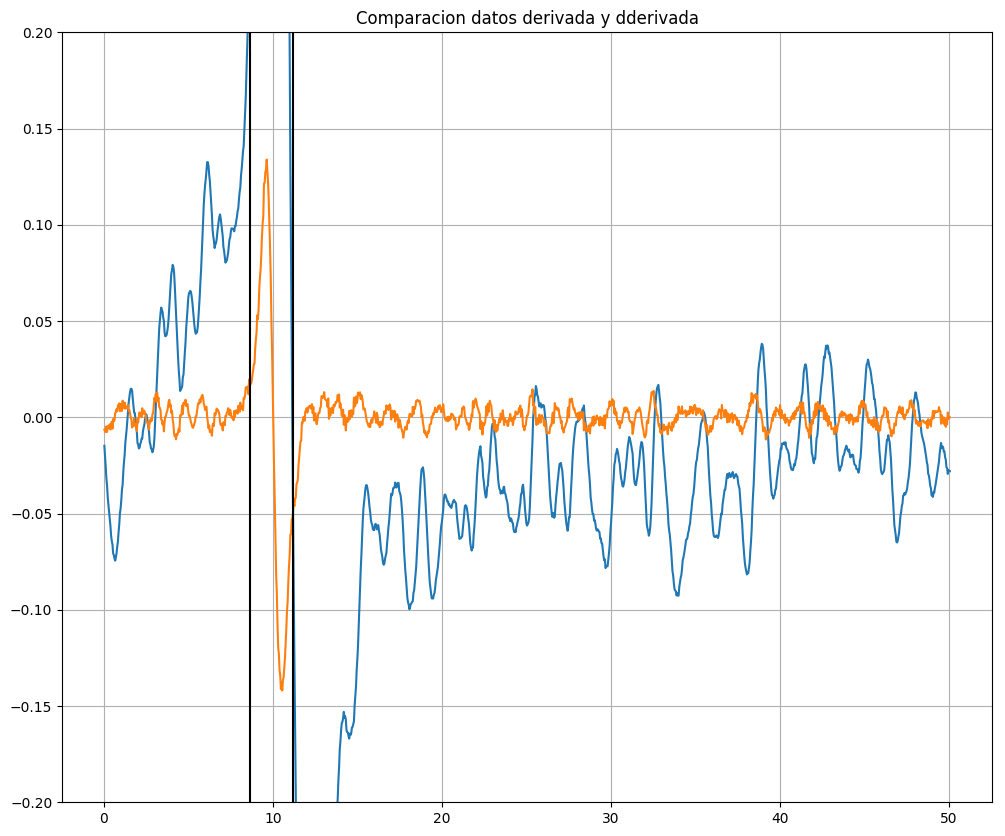

In [80]:
#plot(promSpK)
figure(figsize=(12,10))
title("Comparacion datos derivada y dderivada")
ylim(-0.2,0.2)
plot(rangot,difProm)
plot(rangot,ddprom*0.05)
#plot(rangot,promSpk.+70)
axvline(x=riset[1]/freq, c="black")
axvline(x=riset[2]/freq, c="black")

grid()

# Usaremos LsqFit y una funcion perrona para hacer ajuste por cachos

In [29]:
using LsqFit

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1273


### Vamos a arreglar esto para que las xzeros no necesiten los bordes... a no se yo creo si los vamos a tener que poner de todas formas

In [30]:
function lpp(x, xzeros, yzeros, xini, xfin) 

    
    ll=length(xzeros)+1
    
    if ll!=length(yzeros)-1
        error("tu particion no contiene tantos parametros como necesitas \n
            Te puede faltar un y o te sobra un x")
    end
    if (x<=xini || x>=xfin)
        error("x fuera del dominio")
    end
    
     # las m son las pendientes
    mzeros=zeros(ll)
    kzeros=zeros(ll)
    xaux=vcat(xini, xzeros, xfin)   
    #println(xaux)
    
    for k=1:ll
        mzeros[k]=(yzeros[k+1]-yzeros[k])/(xaux[k+1]-xaux[k])
        kzeros[k]=yzeros[k]-mzeros[k]*xaux[k]
    end
    
    y=0
    
    for k=1:ll
        if xaux[k] <= x < xaux[k+1]
     #       println(xaux[k], " ", x, " ", xaux[k+1])
         y = mzeros[k]*x+kzeros[k]
        elseif  x==xfin
                y=yzero[end]
        
        end
    end
    
    return y

end

lpp (generic function with 1 method)

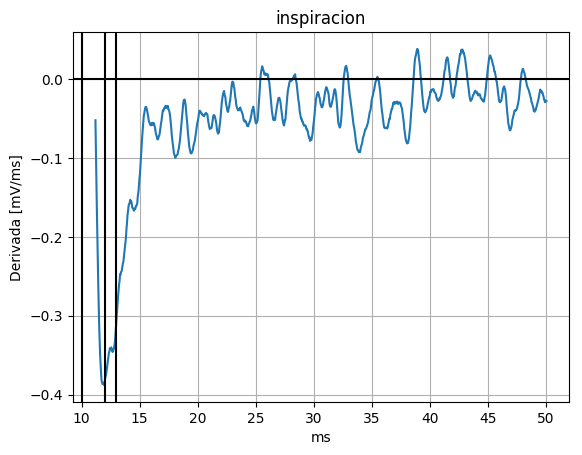

In [31]:
plot(rangot[280:end],difProm[280:end])
xlabel("ms")
ylabel("Derivada [mV/ms]")
axhline([0], c="black")
axvline(10, c="black")
axvline(12, c="black")
axvline(13, c="black")
title("inspiracion")
grid()


# AHORA si es en serio:

In [32]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

280

In [33]:
yyforfit=difProm[ic:end]
xxfofit=rangot[ic:end];

In [34]:
xxfofit

11.2:0.04:50.04

In [35]:
xzeros5=[12,13,15.5]
yzeros5=[-0.0001, -0.4,-0.25, -0.05,-0.0001];


In [36]:
xi=xxfofit[1]
xf=xxfofit[end]
model5(x,p)=map(xr->lpp(xr, p[1:3], p[4:8], xi, xf),x)

model5 (generic function with 1 method)

In [37]:
p_0_5=vcat(xzeros5,yzeros5)

8-element Array{Float64,1}:
 12.0   
 13.0   
 15.5   
 -0.0001
 -0.4   
 -0.25  
 -0.05  
 -0.0001

In [38]:
yys5=map(x->lpp(x, xzeros5, yzeros5,xi,xf), xxfofit[2:end-1]);

In [39]:
fit5 = curve_fit(model5, xxfofit[2:end-1], yyforfit[2:end-1], p_0_5);

In [40]:
pp5=fit5.param

8-element Array{Float64,1}:
 11.703333961471664   
 13.98857731932542    
 15.560009163911978   
 -0.08763190504176102 
 -0.4149414427536649  
 -0.19553542839918314 
 -0.05547088769230578 
 -0.008903043363088463

In [41]:
yyfit5=model5(xxfofit[2:end-1],pp5);

Vamos a sacar nuestro $r^2$


In [42]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit5.-mean(yyforfit)).^2)
rquad5=1-ssreg/sstot

0.10139589940358107

In [43]:
xzeros4=[12,15.5]
yzeros4=[-0.001,-0.45, -0.05,-0.001]
p_0_4=vcat(xzeros4,yzeros4)
xi=xxfofit[1]
xf=xxfofit[end]
model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)

model4 (generic function with 1 method)

In [44]:
fit4 = curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([11.699516585395855, 15.524803038982594, -0.0876329207702101, -0.41245664235134816, -0.055443448307047234, -0.008942611248214046], [-0.022250827240569038, -0.012860395419457937, -0.00200581414102885, 0.0056190249161787165, 0.01306155276299048, 0.014954474180291832, 0.016047350266275018, 0.01612590677530701, 0.01017812648799854, 0.0010014318402706834  …  0.00588811801703433, 0.008265593224374437, 0.008371565434994344, 0.011406312522989667, 0.012740384808577684, 0.01674729494281528, 0.01729403003456169, 0.020301308428215675, 0.01836027069808234, 0.019007941316432256], [0.05207243812816111 0.0 … 0.0 0.0; 0.10414487626259061 0.0 … 0.0 0.0; … ; 0.0 -3.1226984478161897e-6 … 0.0023178195988586073 0.9976821804017775; 0.0 -1.5613492977184688e-6 … 0.0011589097994293036 0.9988410902012067], true, Float64[])

In [45]:
typeof(fit4)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}

In [46]:
pp4=fit4.param;
yyfit4=model4(xxfofit[2:end-1],pp4);

### Hasta aqui fue con el promedio:
Ahora hay que hacerlo para cada una de las diferentes derivadas.


In [47]:
ip=round(Int, 10*freq)
ic=findfirst(x->x<0, difProm[250:end])+ip

dictfits=Dict{String,Dict{Int64, Any}}()

# Primero buscamos la lista de los intervalos ejemplo
@time for k in keys(derivadalimpia)
    dictfits[k]=Dict{Int64, Any}()
    for j in keys(derivadalimpia[k])
        aux=derivadalimpia[k][j]
        #el punto donde comienza el ajuste
        ic=findfirst(x->x<0, aux[250:end])+ip
        yyforfit=aux[ic:end]
        xxfofit=rangot[ic:end];
        xi=xxfofit[1]
        xf=xxfofit[end]
        model4(x,p)=map(xr->lpp(xr, p[1:2], p[3:6], xi, xf),x)
        dictfits[k][j]=curve_fit(model4, xxfofit[2:end-1], yyforfit[2:end-1], p_0_4)
    end
end


  6.645572 seconds (60.49 M allocations: 2.713 GiB, 7.87% gc time)


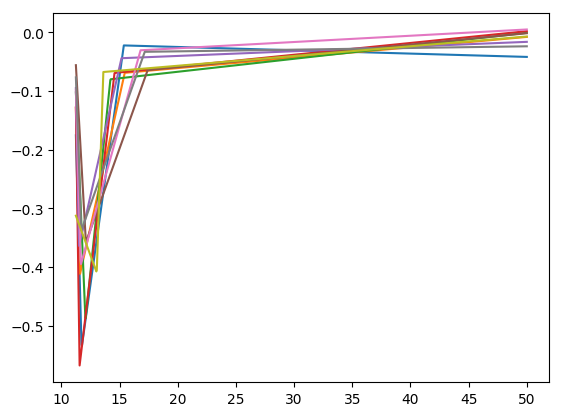

[11.728080506091528, 15.353406746256079, -0.14575981898851098, -0.5388120996422521, -0.022247184259501968, -0.04185230164800108]
[11.589664291074168, 15.440031305517694, -0.09661482644757925, -0.4127006945263283, -0.06893797601983216, -0.007639322721472073]
[12.062791268293134, 14.206844958187025, -0.08352865446332162, -0.49077379828358747, -0.07998697404992043, -0.0006404385668880468]
[11.556369152599629, 14.562269309229572, -0.07195347318018362, -0.5686905472595687, -0.06914274780958762, 0.0021194837126775248]
[11.502018563009564, 15.160000072982047, -0.05346128522040513, -0.3657295299848228, -0.044043139454781416, -0.016118324979453265]
[12.099891208448135, 17.41092905222604, -0.041893491876938, -0.3581822542200379, -0.06430301931620856, -0.0013660254222899058]
[11.65274863482061, 16.799990124586337, -0.06849341948700781, -0.3969972281695765, -0.030504476337997678, 0.004997886664345639]
[11.702446729661531, 17.150508452797244, -0.054104075238772725, -0.33836685002633415, -0.03315341

In [48]:
for k in keys(dictfits)
    for j in keys(dictfits[k])
        aux=dictfits[k][j]
        ppp=aux.param;
        println(ppp)
        yyfit4=model4(xxfofit[2:end-1],ppp);
        plot(xxfofit[2:end-1], yyfit4)
    end
end

In [49]:
yyfit4[1:10]

10-element Array{Float64,1}:
 -0.31261682508938204
 -0.31477801147423823
 -0.31693919785909463
 -0.31910038424395093
 -0.3212615706288072 
 -0.3234227570136635 
 -0.3255839433985198 
 -0.3277451297833761 
 -0.3299063161682324 
 -0.3320675025530887 

In [50]:
yys4=map(x->lpp(x, xzeros4, yzeros4,xi,xf), xxfofit[2:end-1]);

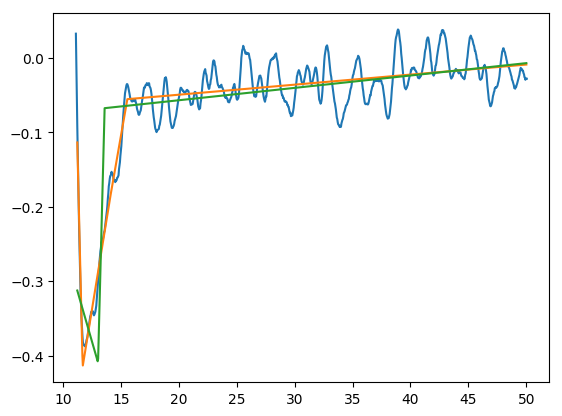

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9693d79748>

In [51]:
plot(rangot[278:end],difProm[278:end])
plot(xxfofit[2:end-1], yyfit5)
plot(xxfofit[2:end-1], yyfit4)


In [52]:
sstot=sum((yyforfit.-mean(yyforfit)).^2)
ssreg=sum((yyfit4.-mean(yyforfit)).^2)
rquad4=1-ssreg/sstot

0.0724789641859298

In [53]:
paso=1/freq
tts=0:paso:50

0.0:0.04:50.0

In [54]:
freq

25.0

In [55]:
np=pyimport("numpy")

UndefVarError: UndefVarError: pyimport not defined

In [56]:
piezas=np[:piecewise]
piezas

UndefVarError: UndefVarError: np not defined

## A partir de aquí estamos guardando datos

In [57]:
using DelimitedFiles

In [61]:
datos=hcat(promSpk,difProm)

1251×2 Array{Float64,2}:
 -71.2207  -0.0148286
 -71.2213  -0.0199678
 -71.2221  -0.0257113
 -71.2231  -0.0319015
 -71.2244  -0.0356833
 -71.2258  -0.0417455
 -71.2275  -0.0455429
 -71.2293  -0.04907  
 -71.2313  -0.053713 
 -71.2334  -0.0566312
 -71.2357  -0.0616848
 -71.2382  -0.0643485
 -71.2407  -0.0661112
   ⋮                 
 -70.3124  -0.0151738
 -70.313   -0.0153696
 -70.3137  -0.0176932
 -70.3144  -0.0177453
 -70.3151  -0.0207262
 -70.3159  -0.0220063
 -70.3168  -0.0259594
 -70.3178  -0.0264522
 -70.3189  -0.0294056
 -70.3201  -0.0274107
 -70.3212  -0.0280044
 -70.3223  -0.0280044

In [62]:
writedlm("../h5files/masterspikelet.dat", datos)

SystemError: SystemError: opening file "../h5files/masterspikelet.dat": No such file or directory

In [64]:
nota="Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  "*nomine

"Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  /home/karel/ABFiles/Jose/180718_9.hf5"

In [65]:
h5open("../h5files/masterspiklet.h5", "w") do file
   write(file, "voltaje", promSpK[2:end])  # alternatively, say "@write file A"
    write(file, "derivative", difProm)  # alternatively, say "@write file A"
    write(file, "nota", nota)  # alternatively, say "@write file A"
end


HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1557 in H5F_open(): unable to open file: time = Mon Jan 27 16:27:23 2020
, name = '../h5files/masterspiklet.h5', tent_flags = 13
    major: File accessibilty
    minor: Unable to open file
  #003: H5FD.c line 734 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #004: H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = '../h5files/masterspiklet.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242
    major: File accessibilty
    minor: Unable to open file


ErrorException: Error creating file ../h5files/masterspiklet.h5

In [ ]:

test = h5open("../h5files/masterspiklet.h5", "r");
names(test)

In [ ]:
#using HDF5